# 範例 : (Kaggle)房價預測
***
- 分數以網站評分結果為準, 請同學實際將提交檔(*.csv)上傳試試看  
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/submit

# [教學目標]
- 以下用房價預測資料, 觀查混合泛化 (Blending) 的寫法與效果

# [範例重點]
- 觀察混合泛化的準確度 (In[12]), 是否比單一模型準確度為高 (In[9~11])  
- 除了我們的權重, 同學也可以試著自行調整權重 (注意:權重和=1), 看看有什麼影響

In [1]:
# 做完特徵工程前的所有準備
import pandas as pd
import numpy as np
import copy, time
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder

data_path = '../data/'
df_train = pd.read_csv(data_path + 'house_train.csv.gz')
df_test = pd.read_csv(data_path + 'house_test.csv.gz')

train_Y = np.log1p(df_train['SalePrice'])
ids = df_test['Id']
df_train = df_train.drop(['Id', 'SalePrice'] , axis=1)
df_test = df_test.drop(['Id'] , axis=1)
df = pd.concat([df_train, df_test])
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [2]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))
na_check(df)

,Missing Ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797
LotFrontage,16.649538
GarageFinish,5.447071
GarageYrBlt,5.447071
GarageQual,5.447071
GarageCond,5.447071


In [3]:
# 以下 In[3]~In[7] 只是摘錄房產預測中的一組特徵工程, 並以此組特徵工程跑參數, 若更換其他特徵工程, In[8]的參數需要重新跑
# 部分欄位缺值補 'None'
none_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'FireplaceQu', 'FireplaceQu', 'FireplaceQu', 
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
             'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'Functional', 'MSSubClass']
for col in none_cols:
    df[col] = df[col].fillna("None")
    
# 部分欄位缺值填補 0
zero_cols = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 
             'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']
for col in zero_cols:
    df[col] = df[col].fillna(0)

In [4]:
# 部分欄位缺值補眾數
mode_cols = ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']
for col in mode_cols:
    df[col] = df[col].fillna(df[col].mode()[0])
    
# 'LotFrontage' 有空缺時, 以同一區 (Neighborhood) 的 LotFrontage 中位數填補 (可以視為填補一種群聚編碼 )
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

# Utilities 參考資訊很少, 所以直接捨棄
df = df.drop(['Utilities'], axis=1)

In [5]:
# 做完各種補缺值, 確認一下有沒有遺漏
na_check(df)

,Missing Ratio


In [6]:
# 四個數值欄位, 因為相異值有限, 轉成文字
label_cols = ['MSSubClass', 'OverallCond', 'YrSold', 'MoSold']
for col in mode_cols:
    df[col] = df[col].astype(str)
    
# 相異值不太具有代表性的, 做標籤編碼
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(df[c].values)) 
    df[c] = lbl.transform(list(df[c].values))
    
# 由地下室面積 + 1樓面積 + 2樓面積, 計算總坪數特徵   
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']    
    
# 看看目前特徵工程的結果
print('Shape df: {}'.format(df.shape))
df.head()

Shape df: (2919, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF
0,5,RL,65.0,8450,1,1,3,Lvl,Inside,0,...,0,3,4,None,0,1,2,WD,Normal,2566.0
1,0,RL,80.0,9600,1,1,3,Lvl,FR2,0,...,0,3,4,None,0,4,1,WD,Normal,2524.0
2,5,RL,68.0,11250,1,1,0,Lvl,Inside,0,...,0,3,4,None,0,8,2,WD,Normal,2706.0
3,6,RL,60.0,9550,1,1,0,Lvl,Corner,0,...,0,3,4,None,0,1,0,WD,Abnorml,2473.0
4,5,RL,84.0,14260,1,1,0,Lvl,FR2,0,...,0,3,4,None,0,11,2,WD,Normal,3343.0


In [7]:
# 把剩下少數重要的類別型欄位, 做獨熱編碼 (已變成數字的欄位, 會自動跳過)
df = pd.get_dummies(df)
print(df.shape)

(2919, 221)


In [9]:
# 將前述轉換完畢資料 df , 重新切成 train_X, test_X
train_num = train_Y.shape[0]
train_X = df[:train_num]
test_X = df[train_num:]

# 使用三種模型 : 線性迴歸 / 梯度提升機 / 隨機森林, 參數使用 Random Search 尋找
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
linear = LinearRegression(normalize=False, fit_intercept=True, copy_X=True)
gdbt = GradientBoostingRegressor(tol=0.1, subsample=0.37, n_estimators=200, max_features=20, 
                                 max_depth=6, learning_rate=0.03)
rf = RandomForestRegressor(n_estimators=300, min_samples_split=9, min_samples_leaf=10, 
                           max_features='sqrt', max_depth=8, bootstrap=False)

In [10]:
# 線性迴歸預測檔 (結果有部分隨機, 請以 Kaggle 計算的得分為準, 以下模型同理)
linear.fit(train_X, train_Y)
linear_pred = linear.predict(test_X)
sub = pd.DataFrame({'Id': ids, 'SalePrice': np.expm1(linear_pred)})
sub.to_csv('../kaggle/house_linear.csv', index=False) 

In [11]:
# 梯度提升機預測檔 
gdbt.fit(train_X, train_Y)
gdbt_pred = gdbt.predict(test_X)
sub = pd.DataFrame({'Id': ids, 'SalePrice': np.expm1(gdbt_pred)})
sub.to_csv('../kaggle/house_gdbt.csv', index=False)

In [12]:
# 隨機森林預測檔
rf.fit(train_X, train_Y)
rf_pred = rf.predict(test_X)
sub = pd.DataFrame({'Id': ids, 'SalePrice': np.expm1(rf_pred)})
sub.to_csv('../kaggle/house_rf.csv', index=False)

In [13]:
# 混合泛化預測檔 (依 Kaggle 傳回分數調整比重, 越準確者比重越高, 依資料性質有所不同)
blending_pred = linear_pred*0.30 + gdbt_pred*0.67 + rf_pred*0.03
sub = pd.DataFrame({'Id': ids, 'SalePrice': np.expm1(blending_pred)})
sub.to_csv('../kaggle/house_blending.csv', index=False)

house_blending.csv    (Public Score: 0.12578)
https://www.kaggle.com/submissions/11616843/11616843.raw

house_rf.csv    (Public Score: 0.16595)
https://www.kaggle.com/submissions/11616836/11616836.raw

house_gdbt.csv    (Public Score: 0.12905)
https://www.kaggle.com/submissions/11616757/11616757.raw

house_linear.csv    (Public Score: 0.13765)
https://www.kaggle.com/submissions/11616748/11616748.raw


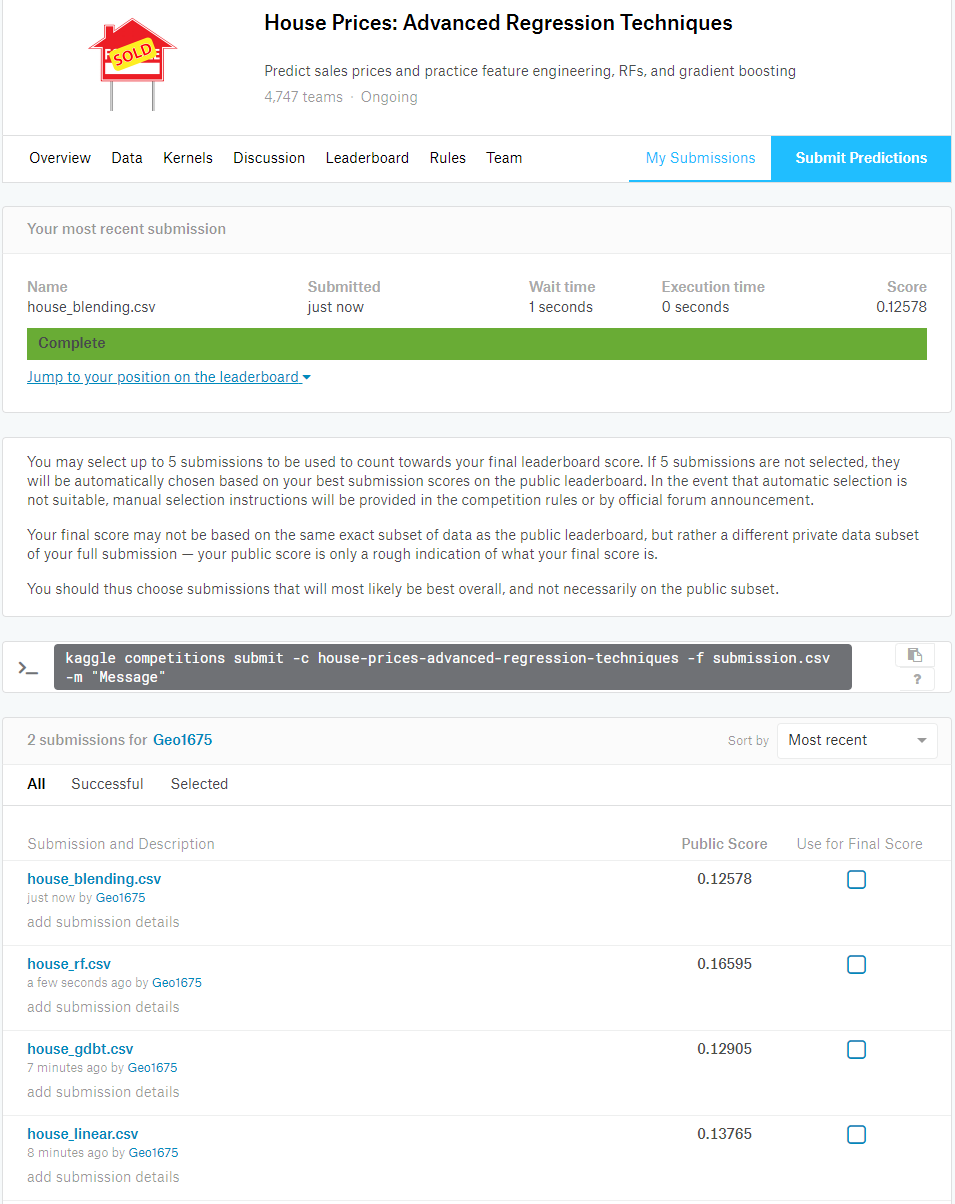